In [ ]:
corpus = [
    'I went yesterday'   ,
    'I will go today',

    'he is my brother',
    'she is my sister', 
    'he is a boy',
    'she is a girl',

    'dominos pizza is famous. ',
    'mcdonals burger is famous ',
    
    'delhi is india capital',
    'beijing is china capital',
    'paris is france capital', ]

In [ ]:
corpus[0].split( )

['I', 'went', 'yesterday']

In [ ]:
X=[]
for i in corpus:
  X.append(i.split( ))

In [ ]:
X

[['I', 'went', 'yesterday'],
 ['I', 'will', 'go', 'today'],
 ['he', 'is', 'my', 'brother'],
 ['she', 'is', 'my', 'sister'],
 ['he', 'is', 'a', 'boy'],
 ['she', 'is', 'a', 'girl'],
 ['dominos', 'pizza', 'is', 'famous.'],
 ['mcdonals', 'burger', 'is', 'famous'],
 ['delhi', 'is', 'india', 'capital'],
 ['beijing', 'is', 'china', 'capital'],
 ['paris', 'is', 'france', 'capital']]

### generate vocabulary

In [ ]:
class Vocabulary:
  def __init__(self):
    self.word2index = {}
    self.word2count = {}
    self.index2word = {}
    self.num_words = 0
    self.num_sentences = 0
    self.longest_sentence = 0

  def add_word(self, word):
    if word not in self.word2index:
        self.word2index[word] = self.num_words
        self.word2count[word] = 1
        self.index2word[self.num_words] = word
        self.num_words += 1
    else:
        # Word exists; increase word count
        self.word2count[word] += 1
            
  def add_sentence(self, sentence):
    sentence_len = 0
    sentence_len +=1
    for word in sentence:
        sentence_len += 1
        self.add_word(word)                                 #remove if padded before
    sentence_len +=1    
    if sentence_len > self.longest_sentence:
        # This is the longest sentence
        self.longest_sentence = sentence_len
    # Count the number of sentences
    self.num_sentences += 1
        

  def seq_to_seq(self,sentence):
    temp=[]   
    for word in sentence:
      # print(word)
      temp.append(self.to_index(word))                                           #remove if padded before
    return temp

  def to_word(self, index):
    return self.index2word[index]

  def to_index(self, word):
    return self.word2index[word]

In [ ]:
v=Vocabulary()
corpus_index=[]
for i in range(len(X)):
  v.add_sentence(X[i])
  corpus_index.append(v.seq_to_seq(X[i]))
corpus_dict=v.word2count
corpus_dict=sorted(corpus_dict.items(), key=lambda x: x[1],reverse=True)
print(corpus_dict)  

[('is', 9), ('capital', 3), ('I', 2), ('he', 2), ('my', 2), ('she', 2), ('a', 2), ('went', 1), ('yesterday', 1), ('will', 1), ('go', 1), ('today', 1), ('brother', 1), ('sister', 1), ('boy', 1), ('girl', 1), ('dominos', 1), ('pizza', 1), ('famous.', 1), ('mcdonals', 1), ('burger', 1), ('famous', 1), ('delhi', 1), ('india', 1), ('beijing', 1), ('china', 1), ('paris', 1), ('france', 1)]


In [ ]:
vocb_size=len(corpus_dict)

### one hot encoding

In [ ]:
import numpy as np


In [ ]:
k=len(corpus_dict)
vocab_one_hot=np.zeros((k,k))
for i in range(len(corpus_dict)):
  vocab_one_hot[i,v.to_index(corpus_dict[i][0])]=1
print((vocab_one_hot[10]))

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


### generate pairs

In [ ]:
window_size=2
input_pairs=[]
for i in range(len(corpus_index)):
  for cen in range(len(corpus_index[i])):
    for j in range(-window_size,window_size+1):
      if((cen+j)>=0 and (cen+j)<len(corpus_index[i]) and j!=0):
        input_pairs.append((corpus_index[i][cen],corpus_index[i][cen+j]))


In [ ]:
input_word_pairs=[]
for i in input_pairs:
  input_word_pairs.append((v.to_word(i[0]),v.to_word(i[1])))
print(input_word_pairs)

[('I', 'went'), ('I', 'yesterday'), ('went', 'I'), ('went', 'yesterday'), ('yesterday', 'I'), ('yesterday', 'went'), ('I', 'will'), ('I', 'go'), ('will', 'I'), ('will', 'go'), ('will', 'today'), ('go', 'I'), ('go', 'will'), ('go', 'today'), ('today', 'will'), ('today', 'go'), ('he', 'is'), ('he', 'my'), ('is', 'he'), ('is', 'my'), ('is', 'brother'), ('my', 'he'), ('my', 'is'), ('my', 'brother'), ('brother', 'is'), ('brother', 'my'), ('she', 'is'), ('she', 'my'), ('is', 'she'), ('is', 'my'), ('is', 'sister'), ('my', 'she'), ('my', 'is'), ('my', 'sister'), ('sister', 'is'), ('sister', 'my'), ('he', 'is'), ('he', 'a'), ('is', 'he'), ('is', 'a'), ('is', 'boy'), ('a', 'he'), ('a', 'is'), ('a', 'boy'), ('boy', 'is'), ('boy', 'a'), ('she', 'is'), ('she', 'a'), ('is', 'she'), ('is', 'a'), ('is', 'girl'), ('a', 'she'), ('a', 'is'), ('a', 'girl'), ('girl', 'is'), ('girl', 'a'), ('dominos', 'pizza'), ('dominos', 'is'), ('pizza', 'dominos'), ('pizza', 'is'), ('pizza', 'famous.'), ('is', 'dominos')

### model 

In [ ]:
import torch
from torch.autograd import Variable
import torch.functional as fun
import torch.nn.functional as nn

In [ ]:

class skip_gram(object):
  def __init__(self):
    super().__init__()
  
    self.seed=1
    self.learning_rate=0.001
    self.vocab_size=vocb_size
    self.latent_dim=12
    self.neg_count=5
    self.W1=Variable(torch.zeros(self.latent_dim,self.vocab_size).float(),requires_grad=True)
    self.W2=Variable(torch.zeros(self.vocab_size,self.latent_dim).float(),requires_grad=True)
    self.Z1=Variable(torch.zeros(self.latent_dim,1).float(),requires_grad=True)
    self.Z2=Variable(torch.zeros(self.vocab_size,1).float(),requires_grad=True)
    self.Y_pred=Variable(torch.zeros(self.vocab_size,1).float(),requires_grad=True)

  def intialize(self) :
    torch.random.manual_seed(self.seed)
    self.W1=Variable(torch.randn(self.latent_dim,self.vocab_size).float(),requires_grad=True)
    self.W2=Variable(torch.randn(self.vocab_size,self.latent_dim).float(),requires_grad=True)

  def forward(self,X):
    self.Z1=torch.matmul(self.W1,X)
    self.Z2=torch.matmul(self.W2, self.Z1)
    self.Y_pred = torch.nn.functional.log_softmax(self.Z2, dim=0)







  def back_propagate(self,x,y):

    loss_fun=nn.nll_loss(self.Y_pred.view(1,-1),y)
    loss =loss_fun.data
    loss_fun.backward()
    
    self.W1.data -= self.learning_rate * self.W1.grad.data
    self.W2.data -= self.learning_rate * self.W2.grad.data

    self.W1.grad.data.zero_()
    self.W2.grad.data.zero_()
    return loss

  def similarity(self,a,b):
    weights=self.W2
    u=weights[a]
    v=weights[b]
    sim=torch.dot(v,u)/(torch.norm(v)*torch.norm(u))
    return sim

## train model

In [ ]:
epochs=5000

In [ ]:
loss_list=[]
import time
start_time = time.time()

model= skip_gram()
model.intialize()

for i in range(epochs):
  losses=0
  for word,context in input_pairs:
    X=Variable(torch.from_numpy(np.array(vocab_one_hot[word]))).float()
    y=Variable(torch.from_numpy(np.array([context]))).long()

    model.forward(X)

    losses += model.back_propagate(X,y)
  loss_list.append(losses)  

print("Total time taken =",  ((time.time() - start_time)))



Total time taken = 101.80388164520264


Text(0, 0.5, 'loss')

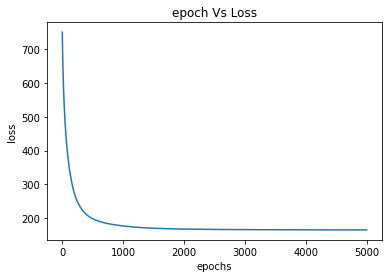

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(loss_list)),loss_list)
plt.title("epoch Vs Loss")
plt.xlabel("epochs")
plt.ylabel("loss")

## similarity of words

In [ ]:
print(v.to_index('brother'))
print(v.to_index('boy'))
print(v.to_index('sister'))
print(v.to_index('girl'))


9
13
11
14


In [ ]:
score=model.similarity(9,13)
print("similarity between (brother,boy) =",score.item())
score=model.similarity(11,14)
print("similarity between (sister,girl) =",score.item())

similarity between (brother,boy) = 0.21565890312194824
similarity between (sister,girl) = 0.23384687304496765


In [ ]:
# brother-boy+girl= sister
new=model.W2[v.to_index('boy')]-model.W2[v.to_index('brother')]+model.W2[v.to_index('sister')]
ori=model.W2[v.to_index('girl')]
compare=torch.dot(new,ori)/(torch.norm(new)*torch.norm(ori))
print("similarity between  (brother-boy+girl ,sister)",compare.item())

similarity between  (brother-boy+girl ,sister) 0.2639784812927246
